# Norm and Dir with CIFAR100
__efficientnetb3 -> b0__

In [1]:
from utils.loss_functions import DKDLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
from torchvision import datasets, transforms, models
import models_package
import time
import json
import random
import logging
from pathlib import Path
import argparse
import warnings
from torch.utils.tensorboard import SummaryWriter
import pdb
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
import boto3
import io
import models_package
from utils.loss_functions import DKDLoss, DirectNormLoss, KDLoss
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import colorstr, Save_Checkpoint, AverageMeter, epoch_loop_reviewkd
from utils.misc_tools import best_LR, best_LR_nd, best_LR_wider, train_teacher, train_teacher_wider, train_teacher_efficientnet, retrieve_teacher_class_weights, new_teacher_class_weights


## Find best LR

In [2]:
# Hyperparameters
learning_rate = 0.003  # 0.01 for resnet34x2 & 0.1 for resnet8 & 0.003 for resnet 8x4
num_epochs = 240
num_workers = 2
batch_size = 64
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

In [3]:
torch.cuda.device_count()

1

## Load in Data

In [4]:
# Load IdenProf dataset
trainloader, testloader  = load_cifar100(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Load in models

### efficientnet

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [7]:
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.our_classifier = nn.Linear(1536, num_classes)

# register the hook
# teacher_model.avgpool.register_forward_hook(get_features('feats'))
teacher_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [8]:
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

In [9]:
# # Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)


criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# ##### FEATURE EXTRACTION LOOP

# # placeholders
# PREDS = []
# FEATS = []

# # placeholder for batch features
# features = {}

# # loop through batches
# for i, (inputs, labels) in enumerate(tqdm(trainloader)):

#     # move to device
#     inputs, labels = inputs.to(device), labels.to(device)
       
#     # forward pass [with feature extraction]
#     preds = teacher_model(inputs)
#     feats = features['feats']
#     emb_feats = torch.flatten(feats, 1)
    
#     # add feats  to lists
#     # FEATS.append(features['feats'].cpu().numpy())

#     # early stop
#     if i == 9:
#         break

  0%|                                                                                               | 0/4167 [00:01<?, ?it/s]


KeyError: 'feats'

## Best LR

In [11]:
def best_LR_here(save_name, model, trainloader, criterion, optimizer, scheduler, 
                num_epochs=5, emb = False, lr_range=(1e-4, 1e-1), plot_loss=True):
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    # create hook for feature embeddings
    model.to(device)
    model.avgpool.register_forward_hook(get_features('feats'))

    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        features = {}
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            # the Norm and Direction models give 2 outputs - feature embeddings and output
            if emb:
                outputs = model(inputs)
                feats = features['feats'].cpu().numpy()
                emb_feats = feats.flatten()

                
                # _, outputs = model(inputs)
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]

    
    plot_path = './figs/LR/'
    os.makedirs(plot_path, exist_ok=True)
    plot_name = str(plot_path + save_name)

    
    if plot_loss:
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.savefig(plot_name, bbox_inches='tight')
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

100%|████████████████████████████████████████████████████████████████████████████████████| 4167/4167 [10:46<00:00,  6.45it/s]


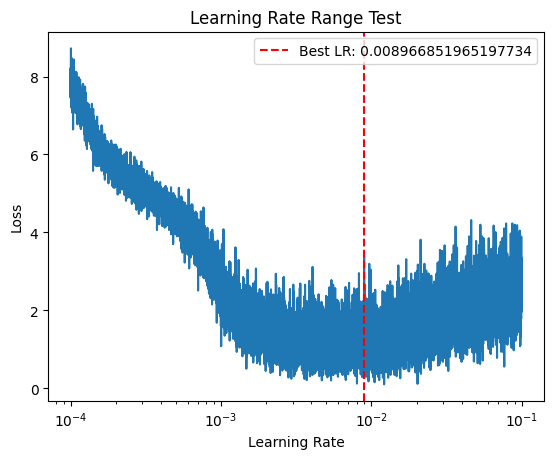

Best learning rate: 0.008966851965197734


0.008966851965197734

In [12]:
teacher_lr = best_LR_here('efficientnetb3_lr', teacher_model, trainloader, 
                     criterion, teacher_optimizer, 
                     teacher_scheduler, num_epochs=3, emb = True)
teacher_lr

100%|████████████████████████████████████████████████████████████████████████████████████| 4167/4167 [10:41<00:00,  6.50it/s]


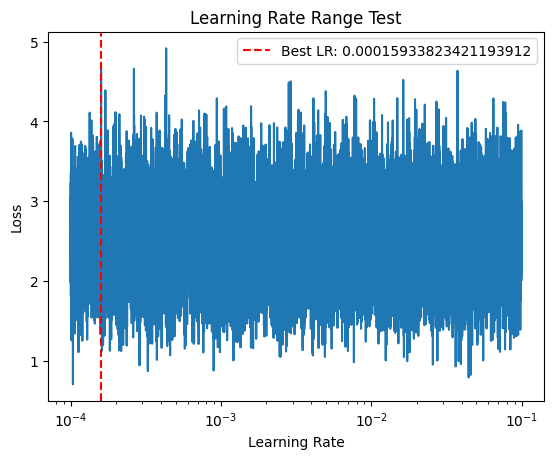

Best learning rate: 0.00015933823421193912


0.00015933823421193912

In [14]:
student_lr = best_LR_here('efficientnetb3_lr', student_model, trainloader, 
                     criterion, student_optimizer, 
                     student_scheduler, num_epochs=3, emb = False)
student_lr

In [10]:
teacher_lr = 0.008966851965197734
student_lr = 0.00015933823421193912

## Train Leaderboard Teacher Models

In [12]:
import time

start = time.time()

teacher_efficientnetb3 = train_teacher_efficientnet('efficientnetb3/wider', teacher_model, trainloader, testloader, criterion, teacher_optimizer, teacher_scheduler, num_epochs=260, patience=5)

end = time.time()

print(f'Training took {(end - start) / 60} minutes')



100%|██████████████████████████████████████████████████████████████████████████████████████| 834/834 [00:42<00:00, 19.57it/s]


*****Epoch 1/260*****
*****Train Loss:  1.846804 Val Loss:  0.655344*****
*****Validation Accuracy: 80.53%*****



100%|██████████████████████████████████████████████████████████████████████████████████████| 834/834 [00:42<00:00, 19.65it/s]


*****Epoch 2/260*****
*****Train Loss:  0.933978 Val Loss:  0.765306*****
*****Validation Accuracy: 76.89%*****



 42%|███████████████████████████████████▋                                                | 1770/4167 [04:21<05:54,  6.77it/s]


KeyboardInterrupt: 

In [11]:
## load saved model
PATH = './weights/efficientnetb3/weights.pth'
teacher_model.load_state_dict(torch.load(PATH))
teacher_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [12]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_weights_efficientnetb3.pth'
teacher_model_path = 'models/testing_teacher_model_efficientnetb3.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')

teacher weights and architecture saved and exported to S3


## Extract Class Embeddings

In [13]:
def get_emb_fea(model, dataloader, batch_size):
    ''' Used to extract the feature embeddings in a teacher model '''
    
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    
    model.eval()
    model.avgpool.register_forward_hook(get_features('feats'))

    EMB = {}


    with torch.no_grad():
        for images, labels in dataloader:
            FEATS = []
            features = {}
            curr_batch_size = len(images)
            images, labels = images.cuda(), labels.cuda()

            # compute output
            # emb_fea, logits = model(images, embed=True)
            outputs = model(inputs)
            # feats = features['feats'].cpu().numpy()
            # emb_fea = feats.flatten()
            FEATS.append(features['feats'].cpu().numpy())
            emb_fea = np.concatenate(FEATS)
            # reshape embedding features to flatten 
            emb_fea = emb_fea.reshape((curr_batch_size, emb_fea.shape[1]))


            for emb, i in zip(emb_fea, labels):
                i = i.item()
                emb_size = len(emb) 
                if str(i) in EMB:
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))
                else:
                    EMB[str(i)] = [[] for _ in range(emb_size)]
                    for j in range(emb_size):
                        EMB[str(i)][j].append(round(emb[j].item(), 4))

    for key, value in EMB.items():
        for i in range(emb_size):
            EMB[key][i] = round(np.array(EMB[key][i]).mean(), 4)

    return EMB


def retrieve_teacher_class_weights(model_name, model, model_weight_path, num_class, data_name, dataloader, batch_size, bucket_name):
    ''' Use the extracted feature embeddings to create a json of class means for teacher'''

    session = boto3.session.Session()
    s3 = session.client('s3')

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, model_weight_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    checkpoint = torch.load(teacher_model_weights_buffer)
    # print("Keys in checkpoint:", checkpoint.keys())
    print("model is loaded properly")

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False
    
    model = model.cuda()

    # emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    # emb_json = json.dumps(emb, indent=4)
    # with open("./class_means/{}_embedding_fea/{}.json".format(data_name, model_name), 'w', encoding='utf-8') as f:
    #     f.write(emb_json)

    emb = get_emb_fea(model=model, dataloader=dataloader, batch_size=batch_size)
    emb_json = json.dumps(emb, indent=4)

    # Create the directory if it doesn't exist
    output_dir = "./class_means/{}_embedding_fea".format(data_name)
    os.makedirs(output_dir, exist_ok=True)

    with open("{}/{}.json".format(output_dir, model_name), 'w', encoding='utf-8') as f:
        f.write(emb_json)

In [55]:
from pathlib import Path
from collections import OrderedDict
import os, shutil

data_name = 'CIFAR100'
retrieve_teacher_class_weights('efficientnetb3', teacher_model, teacher_model_weights_path, num_classes, data_name, testloader, batch_size, bucket_name)


model is loaded properly


# Knowledge Distillation 

In [39]:
## Training script

def train(model, teacher, T_EMB, train_dataloader, optimizer, criterion, kd_loss, nd_loss, epoch, batch_size):

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    
    train_loss = AverageMeter()
    train_error = AverageMeter()

    Cls_loss = AverageMeter()
    Div_loss = AverageMeter()
    Norm_Dir_loss = AverageMeter()

    # test T_EMB
    T_EMB = T_EMB

    # set up hooks
    # model.avgpool.register_forward_hook(get_features('feats'))
    # teacher.avgpool.register_forward_hook(get_features('feats'))

    # Model on train mode
    model.train()
    teacher.eval()

    # # fix embedding output on student model
    # s_emb_size = 1280
    # t_emb_size = 1536
    # model.fc1 = nn.Sequential(
    #     nn.BatchNorm1d(s_emb_size),
    #     nn.Dropout(0.5),
    #     nn.Linear(s_emb_size, t_emb_size)
    #     )
    # for m in model.modules():
    #     if isinstance(m, nn.BatchNorm1d):
    #         m.weight.data.fill_(1)
    #         m.bias.data.zero_()
    #     elif isinstance(m, nn.Linear):
    #         m.bias.data.zero_()

    # ##
    # model.fc1.to(device)
    

    
    step_per_epoch = len(train_dataloader)

    for step, (images, labels) in enumerate(train_dataloader):
        
        start = time.time()
        s_FEATS = []
        features = {}
        curr_batch_size = len(images)
        images, labels = images.cuda(), labels.cuda()

        # compute output
        # emb_fea, logits = model(images, embed=True)
        model.avgpool.register_forward_hook(get_features('feats'))

        s_logits = model(images)

        s_FEATS.append(features['feats'].cpu().numpy())
        s_emb = np.concatenate(s_FEATS)
        # print(f'before reshaping s_emb: {s_emb.shape}')
        # reshape embedding features to flatten 
        s_emb = s_emb.reshape((curr_batch_size, s_emb.shape[1]))
        s_emb = torch.from_numpy(s_emb)
        s_emb = s_emb.to(device)

        # fix embedding output on student model
        s_emb_size = 1280
        t_emb_size = 1536
        
        emb_inflate = nn.Sequential(
            nn.BatchNorm1d(s_emb_size),
            nn.Dropout(0.5),
            nn.Linear(s_emb_size, t_emb_size)
            )
        # # clean_model
        for m in model.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    
        ##
        emb_inflate.to(device)

        s_emb = emb_inflate(s_emb)
        # model.fc1.to(device)
        
        # s_emb = model.fc1(s_emb)

        with torch.no_grad():
                        
            ####
            
            t_FEATS = []
            features = {}
    
            # compute output
            # emb_fea, logits = model(images, embed=True)
            teacher.avgpool.register_forward_hook(get_features('feats'))
            
            t_logits = teacher(images)
    
            t_FEATS.append(features['feats'].cpu().numpy())
            t_emb = np.concatenate(t_FEATS)
            # reshape embedding features to flatten 
            t_emb = t_emb.reshape((curr_batch_size, t_emb.shape[1]))


        ## save s_emb and t_emb as torch tensors 
        # s_emb = torch.from_numpy(s_emb)
        t_emb = torch.from_numpy(t_emb)

        # s_emb = s_emb.to(device)
        t_emb = t_emb.to(device)


        # print(s_emb.size() == s_emb.size())
        # print(s_emb.size())
        # print(s_emb.size())
        
        ###

        # cls loss
        cls_loss = criterion(s_logits, labels) * cls_loss_factor
        # KD loss
        div_loss = kd_loss(s_out = s_logits, t_out = t_logits) * min(1.0, epoch/warm_up)
        # ND loss
        norm_dir_loss = nd_loss(s_emb=s_emb, t_emb=t_emb, T_EMB=T_EMB, labels=labels)

        loss = cls_loss + div_loss + norm_dir_loss
        # measure accuracy and record loss
        batch_size = images.size(0)
        _, pred = s_logits.data.cpu().topk(1, dim=1)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        Cls_loss.update(cls_loss.item(), batch_size)
        Div_loss.update(div_loss.item(), batch_size)
        Norm_Dir_loss.update(norm_dir_loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
        s1 = '\r{} [{}/{}]'.format(t, step+1, step_per_epoch)
        s2 = ' - {:.2f}ms/step - nd_loss: {:.3f} - kd_loss: {:.3f} - cls_loss: {:.3f} - train_loss: {:.3f} - train_acc: {:.3f}'.format(
             1000 * (time.time() - start), norm_dir_loss.item(), div_loss.item(), cls_loss.item(), train_loss.val, 1-train_error.val)

        print(s1+s2, end='', flush=True)

    print()
    return Norm_Dir_loss.avg, Div_loss.avg, Cls_loss.avg, train_loss.avg, train_error.avg


def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    # Model on eval mode
    model.eval()


    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()
            
            # compute logits
            logits = model(images)

            loss = criterion(logits, labels)

            # measure accuracy and record loss
            batch_size = images.size(0)
            _, pred = logits.data.cpu().topk(1, dim=1)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg


def epoch_loop(model, teacher, train_loader, test_loader, num_class, T_EMB, save_dir, batch_size, logger):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # model = nn.DataParallel(model, device_ids=args.gpus)
    # model = nn.DataParallel(model)
    model = model
    model.to(device)
    # teacher = nn.DataParallel(teacher, device_ids=args.gpus)
    # teacher = nn.DataParallel(teacher)
    teacher = teacher
    teacher.to(device)

    # model.avgpool.register_forward_hook(get_features('s_feats'))
    # teacher.avgpool.register_forward_hook(get_features('t_feats'))

    # loss
    criterion = nn.CrossEntropyLoss().to(device)
    kd_loss = KDLoss(kl_loss_factor=kd_loss_factor, T=t).to(device)
    nd_loss = DirectNormLoss(num_class=num_class, nd_loss_factor=nd_loss_factor).to(device)
    # optimizer
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)

    # weights
    save_dir = Path(save_dir)
    weights = save_dir / 'weights'
    weights.mkdir(parents=True, exist_ok=True)
    last = weights / 'last'
    best = weights / 'best'

    # acc,loss
    acc_loss = save_dir / 'acc_loss'
    acc_loss.mkdir(parents=True, exist_ok=True)

    train_acc_savepath = acc_loss / 'train_acc.npy'
    train_loss_savepath = acc_loss / 'train_loss.npy'
    val_acc_savepath = acc_loss / 'val_acc.npy'
    val_loss_savepath = acc_loss / 'val_loss.npy'

    # tensorboard
    logdir = save_dir / 'logs'
    logdir.mkdir(parents=True, exist_ok=True)
    summary_writer = SummaryWriter(logdir, flush_secs=120)


    start_epoch = 0
    best_error = 0
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []

    logger = logger

    # Train model
    best_error = 1
    for epoch in range(start_epoch, epochs):
        if epoch in [150, 180, 210]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        print("Epoch {}/{}".format(epoch + 1, epochs))
        norm_dir_loss, div_loss, cls_loss, train_epoch_loss, train_error = train(model=model,
                                                                                 teacher=teacher,
                                                                                 T_EMB=T_EMB,
                                                                                 train_dataloader=train_loader,
                                                                                 optimizer=optimizer,
                                                                                 criterion=criterion,
                                                                                 kd_loss=kd_loss,
                                                                                 nd_loss=nd_loss,
                                                                                 epoch=epoch,
                                                                                 batch_size = batch_size)
        test_epoch_loss, test_error = test(model=model,
                                           test_dataloader=test_loader,
                                           criterion=criterion)

        s = "Train Loss: {:.3f}, Train Acc: {:.3f}, Test Loss: {:.3f}, Test Acc: {:.3f}, lr: {:.5f}".format(
            train_epoch_loss, 1-train_error, test_epoch_loss, 1-test_error, optimizer.param_groups[0]['lr'])
        logger.info(colorstr('green', s))

        # save acc,loss
        train_loss.append(train_epoch_loss)
        train_acc.append(1-train_error)
        test_loss.append(test_epoch_loss)
        test_acc.append(1-test_error)

        # save model
        is_best = test_error < best_error
        best_error = min(best_error, test_error)
        state = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_error': best_error,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'test_acc': test_acc,
                'test_loss': test_loss,
            }

        last_path = last / 'epoch_{}_loss_{:.3f}_acc_{:.3f}'.format(
            epoch + 1, test_epoch_loss, 1-test_error)
        best_path = best / 'epoch_{}_acc_{:.3f}'.format(
                epoch + 1, 1-best_error)

        Save_Checkpoint(state, last, last_path, best, best_path, is_best)

        # tensorboard
        if epoch == 1:
            images, labels = next(iter(train_loader))

            img_grid = torchvision.utils.make_grid(images)
            summary_writer.add_image('Image', img_grid)
        summary_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
        summary_writer.add_scalar('train_loss', train_epoch_loss, epoch)
        summary_writer.add_scalar('train_error', train_error, epoch)
        summary_writer.add_scalar('val_loss', test_epoch_loss, epoch)
        summary_writer.add_scalar('val_error', test_error, epoch)

        summary_writer.add_scalar('nd_loss', norm_dir_loss, epoch)
        summary_writer.add_scalar('kd_loss', div_loss, epoch)
        summary_writer.add_scalar('cls_loss', cls_loss, epoch)

    summary_writer.close()
    import os
    if not os.path.exists(train_acc_savepath) or not os.path.exists(train_loss_savepath):
        np.save(train_acc_savepath, train_acc)
        np.save(train_loss_savepath, train_loss)
        np.save(val_acc_savepath, test_acc)
        np.save(val_loss_savepath, test_loss)


In [40]:
# set some params
workers = 8 # number of data loading workers
momentum = 0.9 # SGD momentum
cls_loss_factor =1.0 # cls loss weight factor
kd_loss_factor =1.0 #KD loss weight factor
t =4.0 #temperature
nd_loss_factor =1.0 # ND loss weight factor
warm_up=20.0 #loss weight warm up epochs
weight_decay = 5e-4 

def run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_weights_path, num_class, epochs, batch_size, lr):
    
    logging.basicConfig(level=logging.INFO, format='%(asctime)s [line:%(lineno)d] %(message)s',
                        datefmt='%d %b %Y %H:%M:%S')
    logger = logging.getLogger(__name__)
    logger.info(colorstr('green', "Distribute train, total batch size:{}, epoch:{}".format(batch_size, epochs)))
 
    
    # load in models
    model = student_model
    
    teacher = teacher_model
    
    print('Load Teacher Weights')

    ###
    session = boto3.session.Session()
    s3 = session.client('s3')
    bucket_name = '210bucket' 

    teacher_model_weights_buffer = io.BytesIO()
    s3.download_fileobj(bucket_name, teacher_weights_path, teacher_model_weights_buffer)
    teacher_model_weights_buffer.seek(0)  

    # Load the model
    # model = models_package.__dict__[model_name](num_class=num_class)
    teacher_ckpt = torch.load(teacher_model_weights_buffer)
    teacher.load_state_dict(teacher_ckpt)
    # print("Keys in checkpoint:", teacher_ckpt.keys())
    print("model is loaded properly")

        
    # teacher_ckpt = torch.load(teacher_weights)['model']
    # teacher.load_state_dict(teacher_ckpt)

    for param in teacher.parameters():
        param.requires_grad = False

    ## get teacher class mean embeddings
    with open("./class_means/CIFAR100_embedding_fea/efficientnetb3.json", 'r') as f:
        T_EMB = json.load(f)
    f.close()

    logger.info(colorstr('green', 'Use ' + 'efficientnetb3' + ' Training ' + 'efficientnetb0' + ' ...'))


    # Train the model
    epoch_loop(model=model, teacher=teacher, train_loader = trainloader, test_loader = testloader, num_class = num_classes, T_EMB = T_EMB, save_dir = save_dir, batch_size = batch_size, logger = logger)

    

In [41]:
save_dir = './run/CIFAR/KD++'
# teacher_weights = './weights/efficientnetb3/weights.pth'
teacher_weights_path = 'weights/teacher_model_weights_efficientnetb3.pth'
epochs = 260
lr = student_lr

start = time.time()

run_norm_and_dir_kd(save_dir, student_model, teacher_model, teacher_weights_path, num_classes, epochs, batch_size, lr)

end = time.time()

print(f'Training took {(end - start) / 60} minutes')

04 Dec 2023 02:30:21 [line:16] Distribute train, total batch size:64, epoch:2
04 Dec 2023 02:30:21 [line:1255] Found credentials in shared credentials file: ~/.aws/credentials


Load Teacher Weights


04 Dec 2023 02:30:23 [line:54] Use efficientnetb3 Training efficientnetb0 ...


model is loaded properly
Epoch 1/2
2023-12-04 02:38:10 [782/782] - 97.44ms/step - nd_loss: 0.996 - kd_loss: 0.000 - cls_loss: 2.801 - train_loss: 3.797 - train_acc: 0.5623


04 Dec 2023 02:38:40 [line:266] Train Loss: 4.036, Train Acc: 0.468, Test Loss: 2.715, Test Acc: 0.506, lr: 0.00016


Epoch 2/2
2023-12-04 02:46:29 [782/782] - 96.41ms/step - nd_loss: 1.005 - kd_loss: 0.001 - cls_loss: 2.719 - train_loss: 3.725 - train_acc: 0.3759


04 Dec 2023 02:46:59 [line:266] Train Loss: 3.585, Train Acc: 0.516, Test Loss: 2.298, Test Acc: 0.555, lr: 0.00016


Training took 16.659524206320445 minutes
